<a href="https://colab.research.google.com/github/mrymsadeghi/Colab_notebooks/blob/main/Yolov7_ANPR_ir.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
%cd /content/gdrive/MyDrive
!git clone https://github.com/augmentedstartups/yolov7.git
%cd yolov7
!pip install -r requirements.txt
!pip install roboflow

/content/gdrive/MyDrive
fatal: destination path 'yolov7' already exists and is not an empty directory.
/content/gdrive/MyDrive/yolov7
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 596 kB 6.6 MB/s 
     |████████████████████████████████| 1.6 MB 65.0 MB/s 
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 145 kB 7.0 MB/s 
     |████████████████████████████████| 178 kB 59.1 MB/s 
     |████████████████████████████████| 1.1 MB 23.0 MB/s 
     |████████████████████████████████| 67 kB 6.9 MB/s 
     |████████████████████████████████| 54 kB 3.0 MB/s 
     |████████████████████████████████| 138 kB 72.5 MB/s 
     |████████████████████████████████| 62 kB 1.5 MB/s 
  Cre

In [ ]:
%cd /content/gdrive/MyDrive/yolov7

from roboflow import Roboflow
rf = Roboflow(api_key="VdwBRxsJsFmCMW94xJjd")
project = rf.workspace("object-detection-yolov5").project("anpr_ir")
dataset = project.version(1).download("yolov7")

/content/gdrive/MyDrive/yolov7
loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to ANPR_ir-1 in yolov7pytorch:: 100%|██████████| 3530/3530 [18:20<00:00,  3.21it/s]


In [ ]:
%%bash
wget -P /content/gdrive/MyDrive/yolov7 https://github.com/WongKinYiu/yolov7/releases/download/v0.1/yolov7.pt

In [ ]:
!python train.py --batch 16 --cfg cfg/training/yolov7.yaml --epochs 15 --data /content/gdrive/MyDrive/yolov7/ANPR_ir-1/data.yaml --weights 'yolov7.pt' --device 0 

In [ ]:
from IPython.display import Image

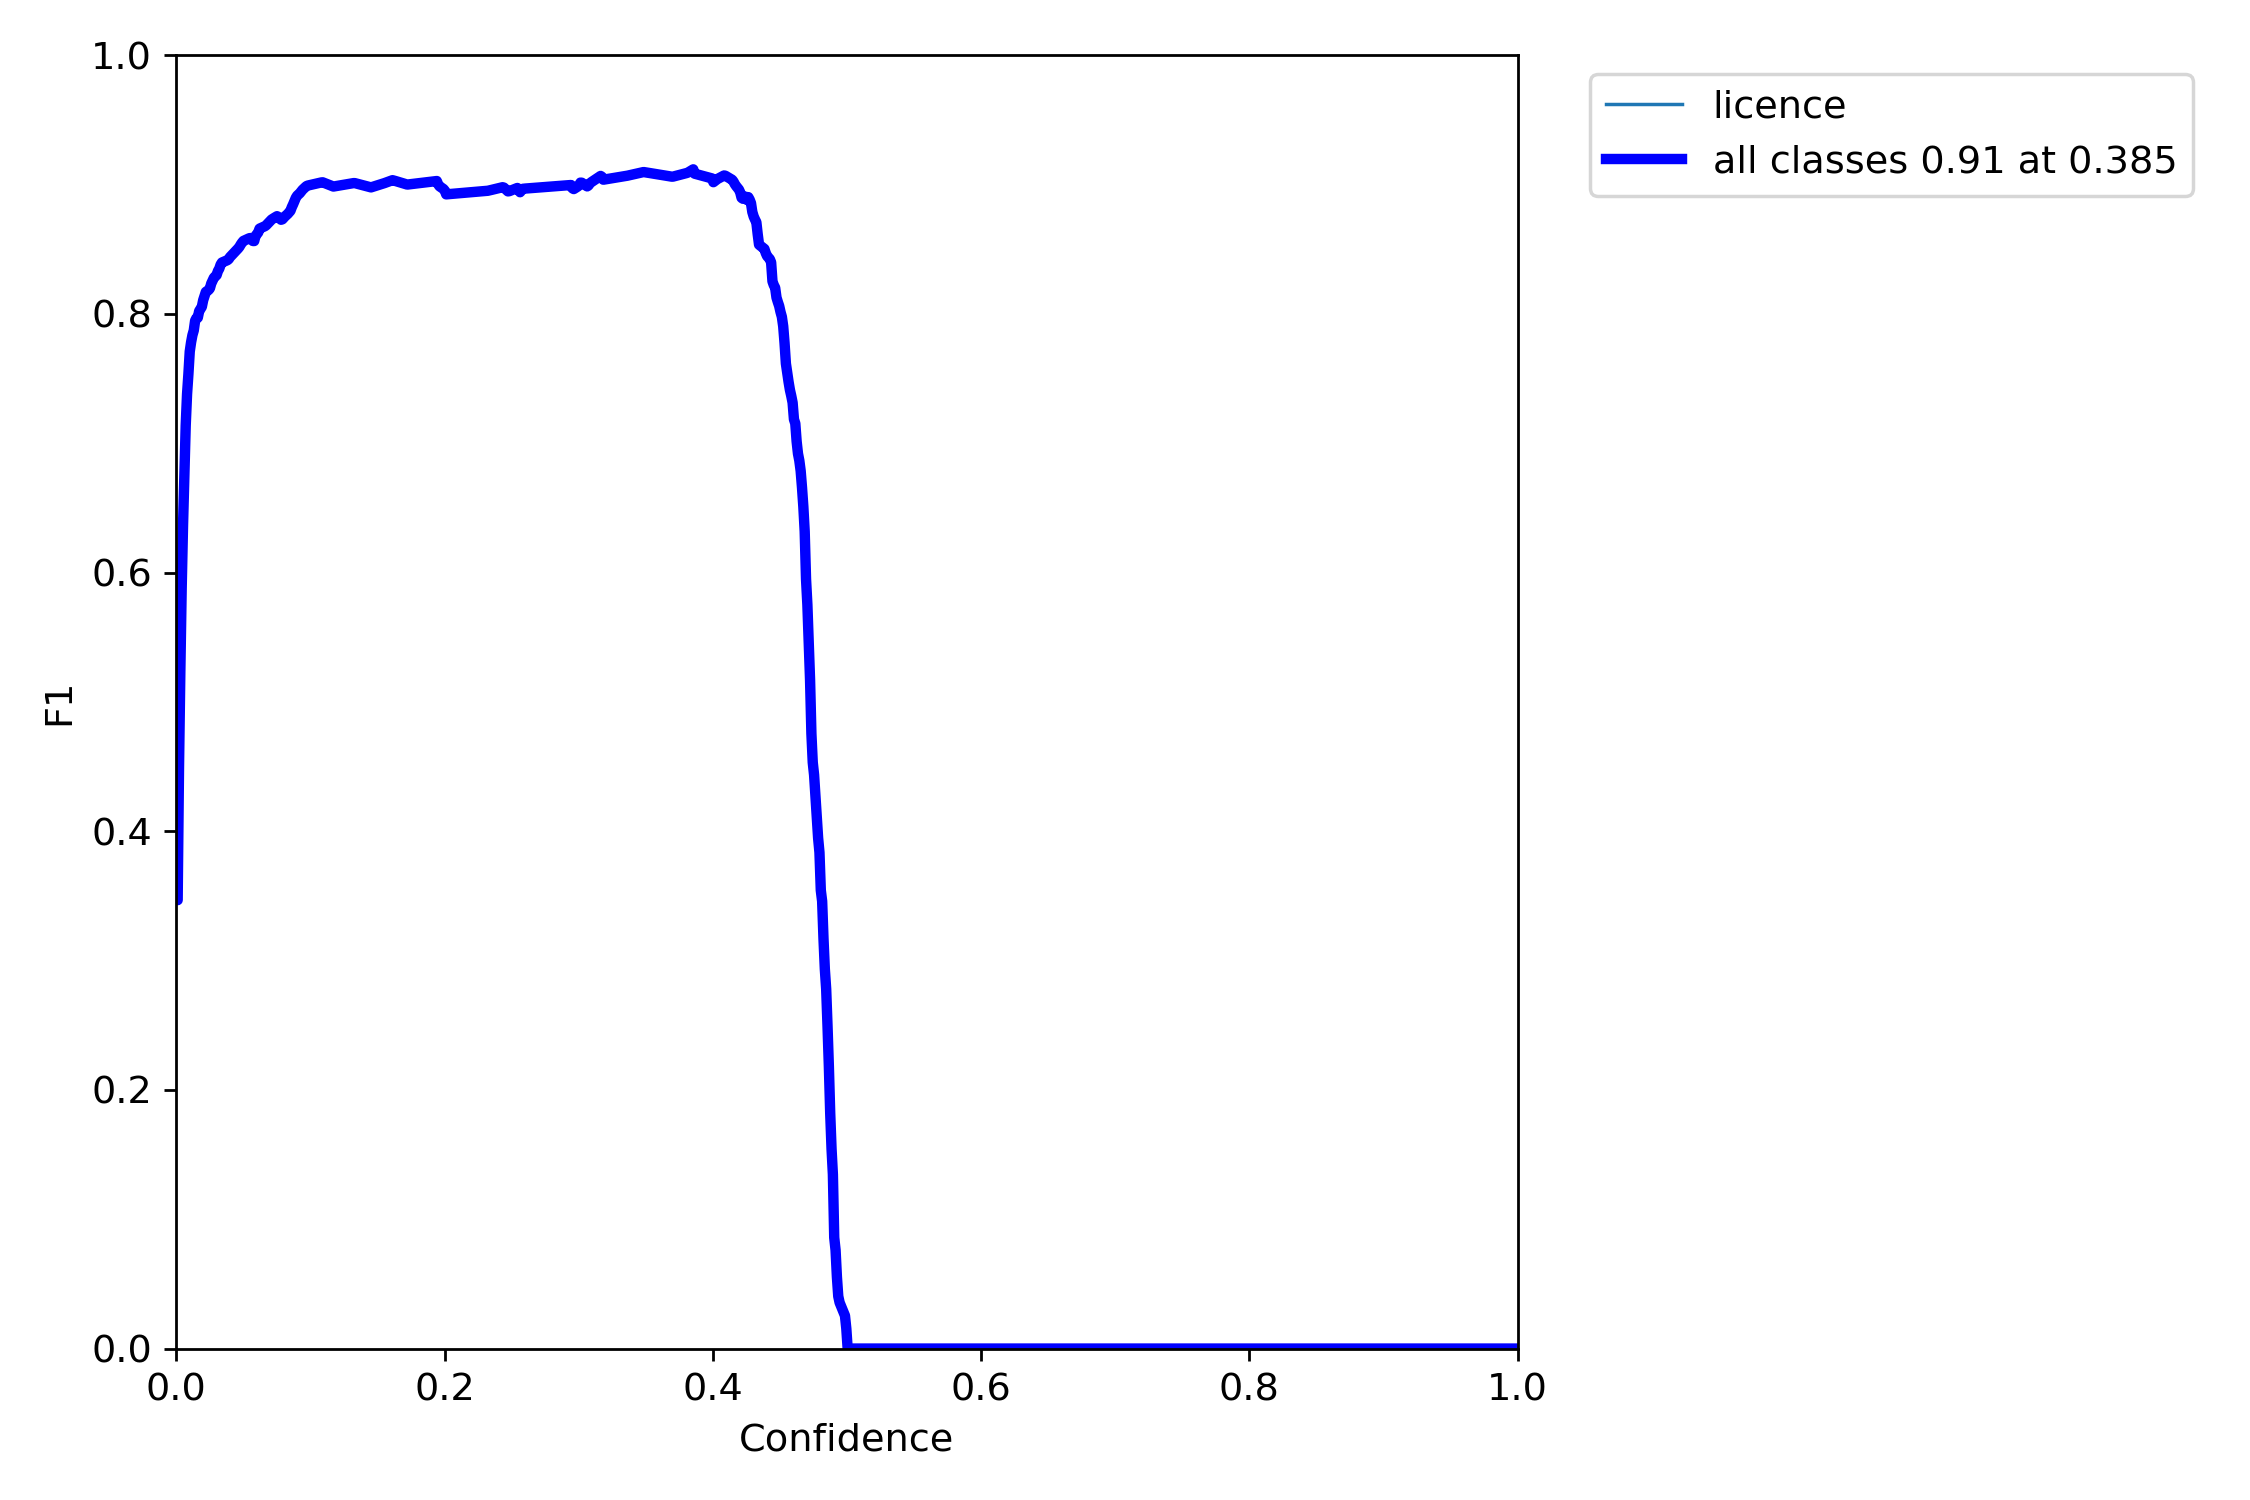

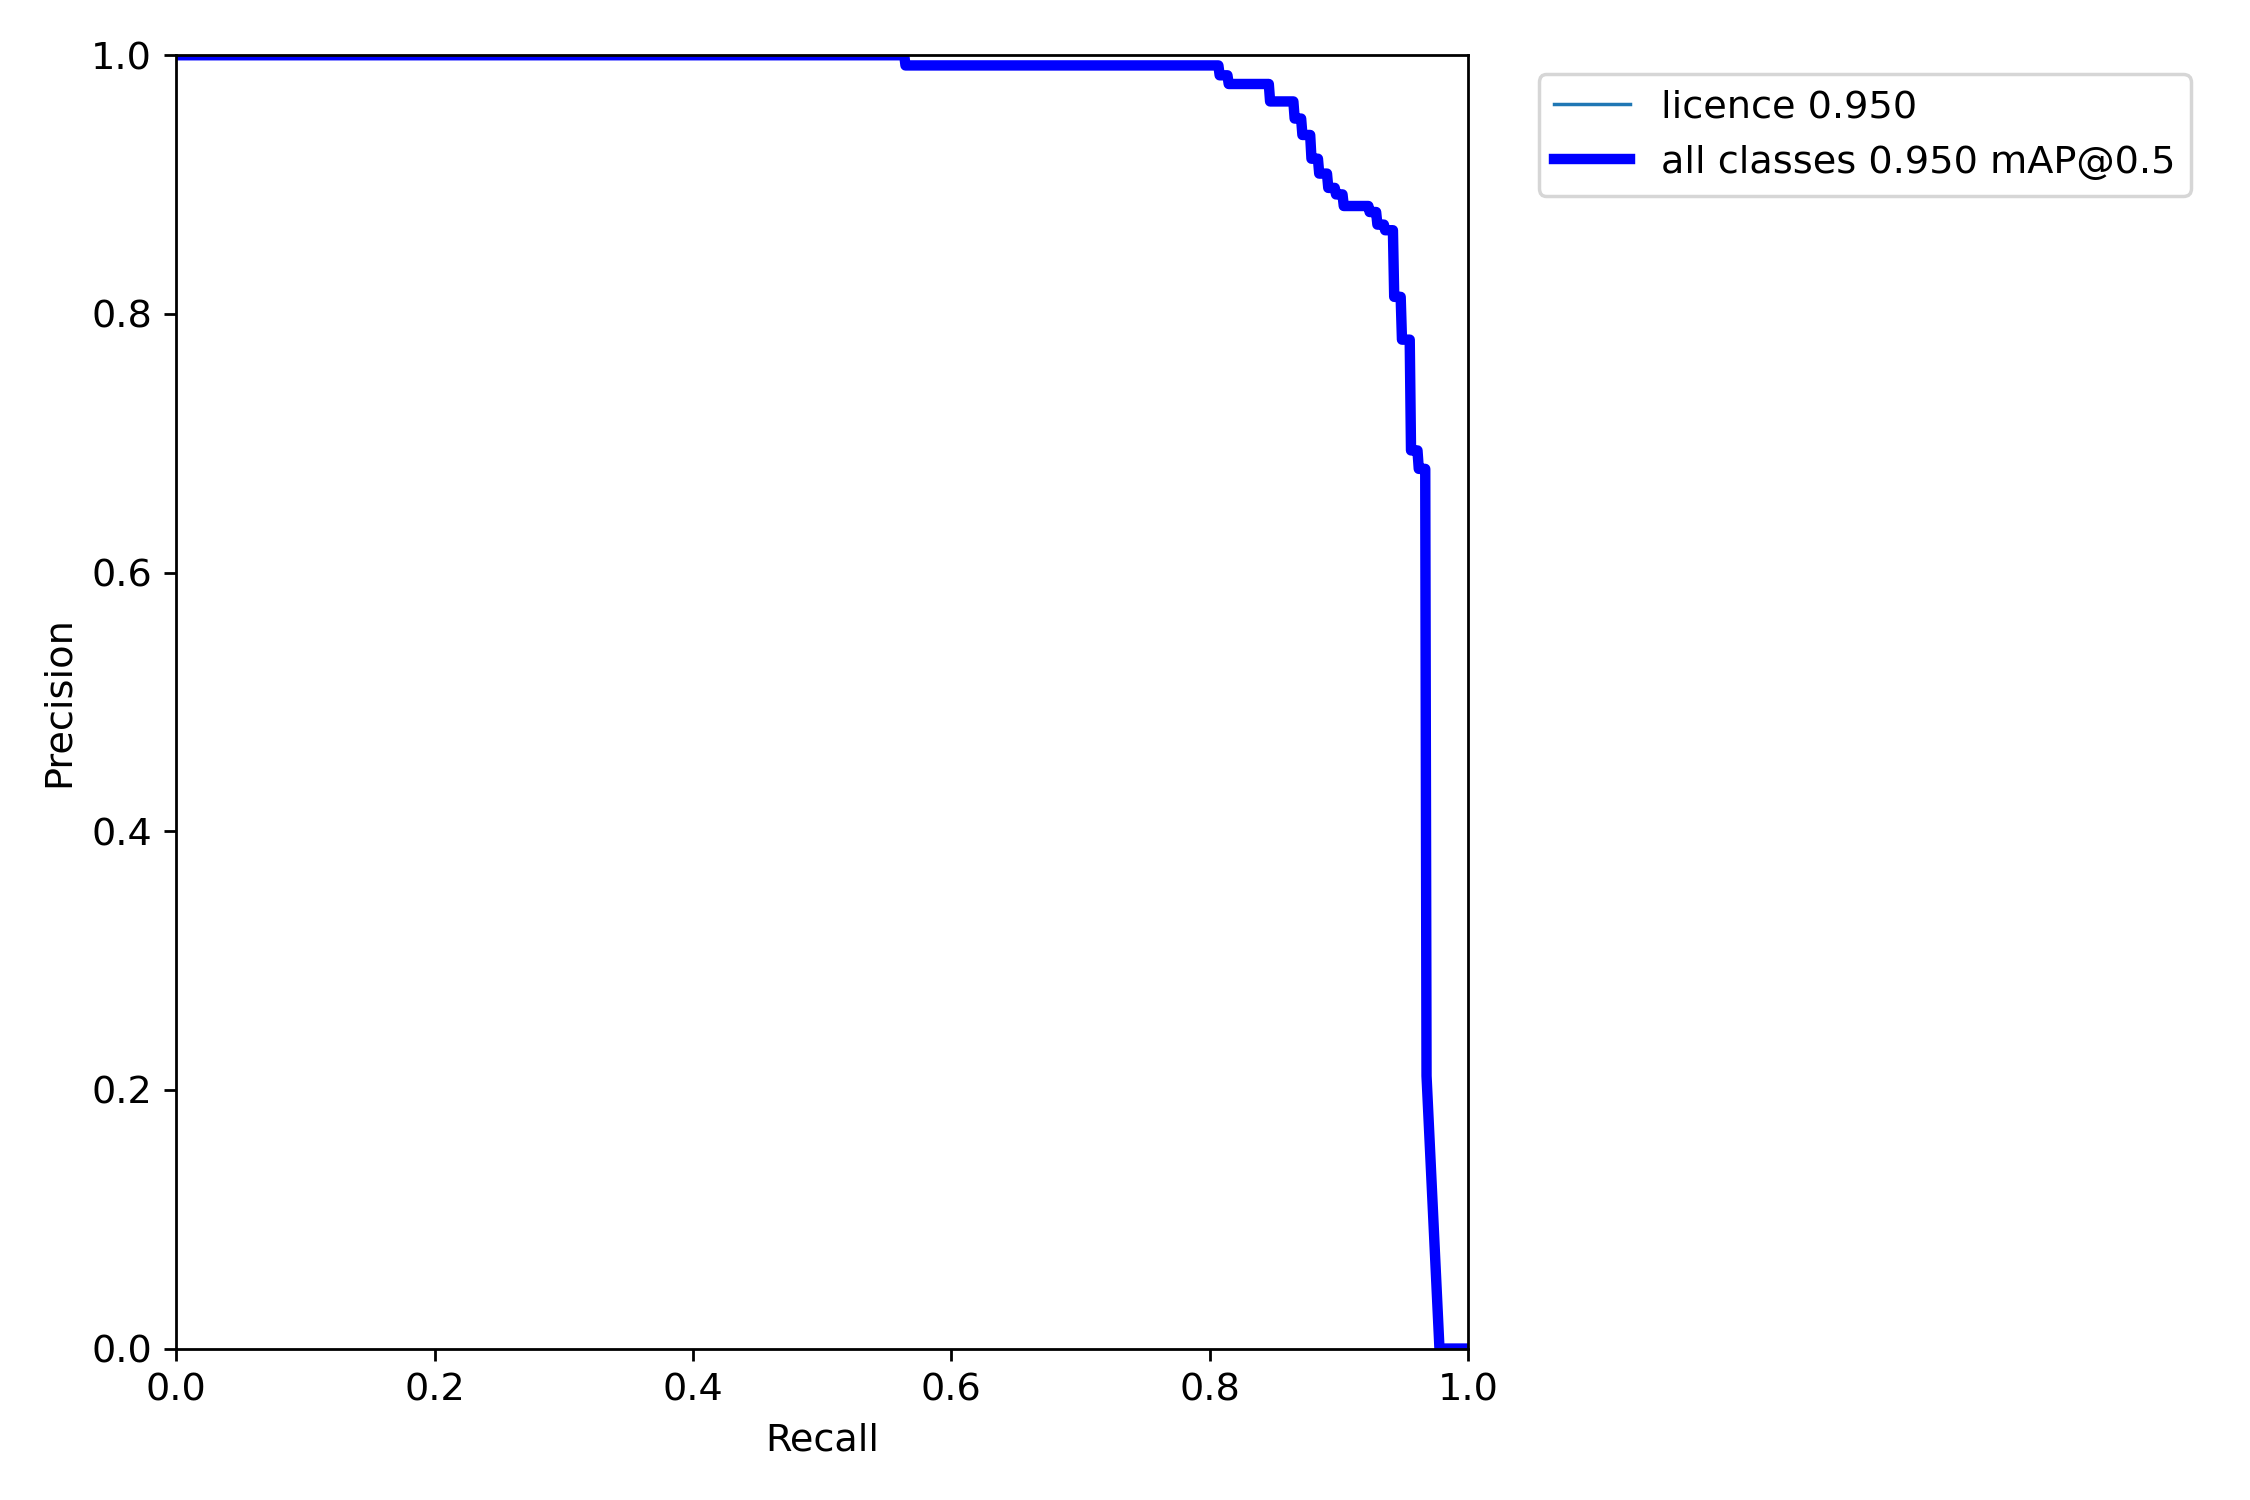

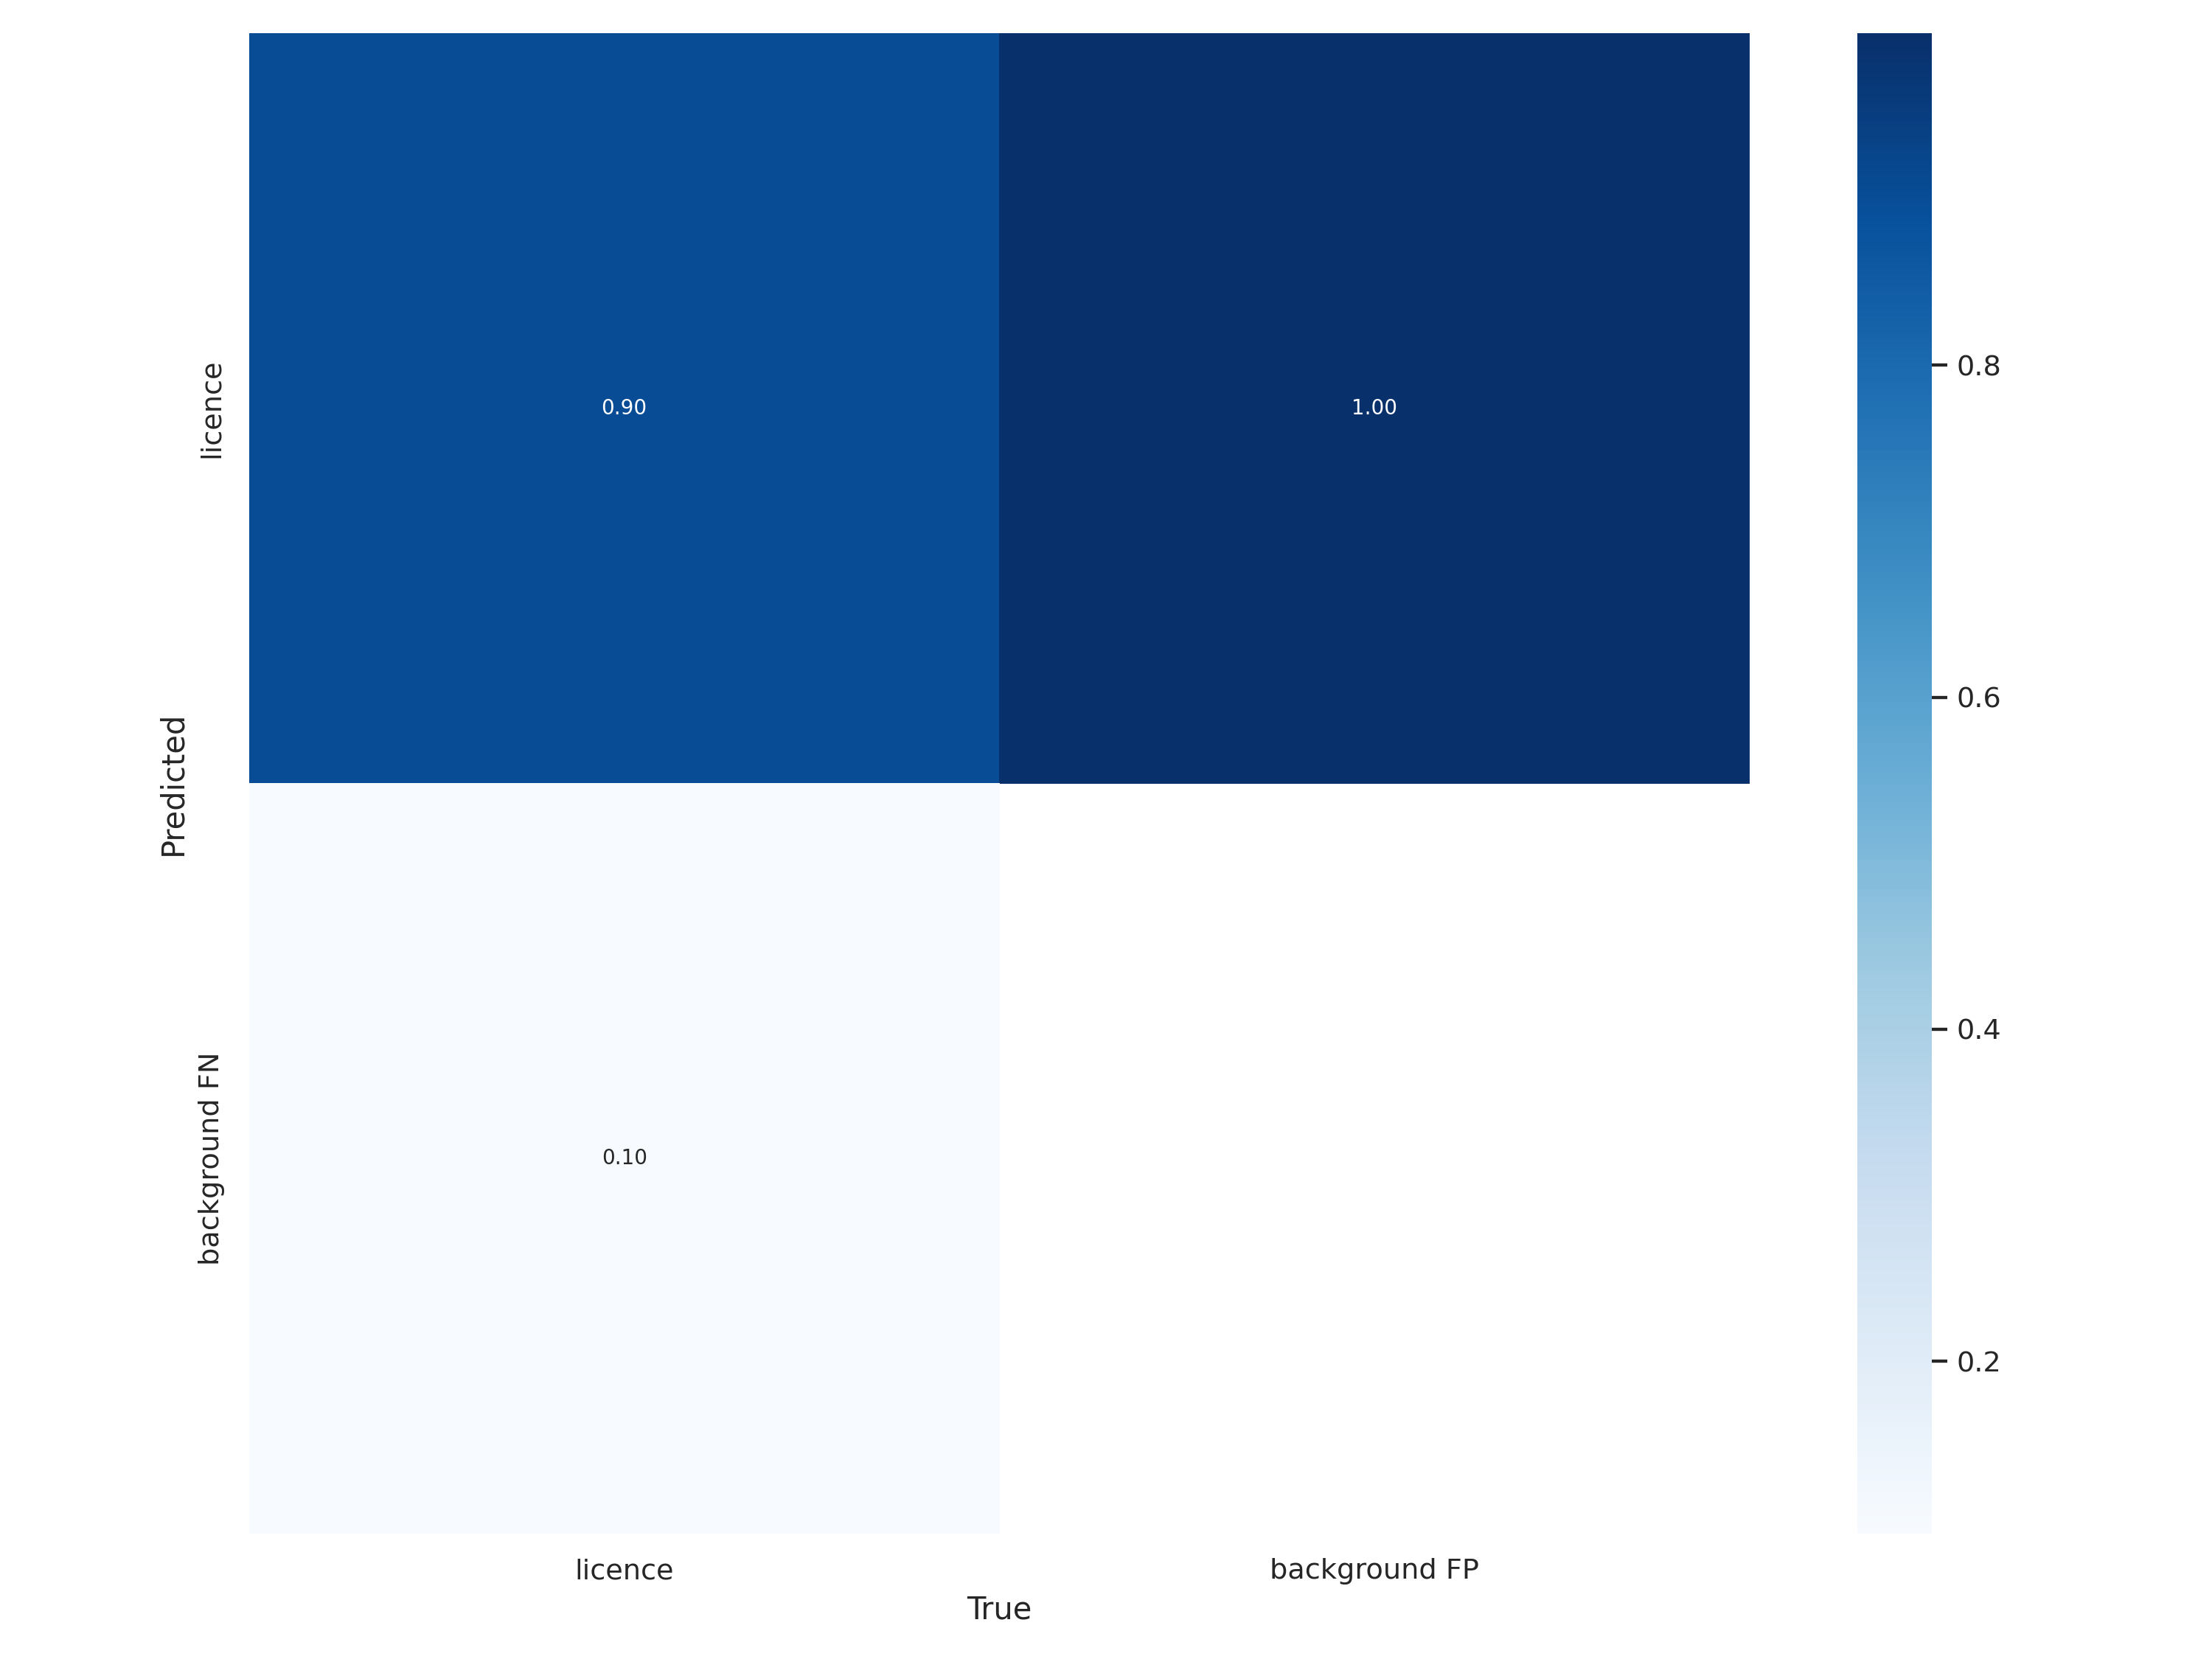

In [ ]:
display(Image("/content/gdrive/MyDrive/yolov7/runs/train/exp/F1_curve.png", width=400, height=400))
display(Image("/content/gdrive/MyDrive/yolov7/runs/train/exp/PR_curve.png", width=400, height=400))
display(Image("/content/gdrive/MyDrive/yolov7/runs/train/exp/confusion_matrix.png", width=500, height=500))

In [ ]:
!python detect.py --weights /content/gdrive/MyDrive/yolov7/runs/train/exp/weights/best.pt --conf 0.1 --source /content/gdrive/MyDrive/yolov7/ANPR_ir-1/test/images

Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.1, device='', exist_ok=False, img_size=640, iou_thres=0.45, name='exp', no_trace=False, nosave=False, project='runs/detect', save_conf=False, save_txt=False, source='/content/gdrive/MyDrive/yolov7/ANPR_ir-1/test/images', update=False, view_img=False, weights=['/content/gdrive/MyDrive/yolov7/runs/train/exp/weights/best.pt'])
YOLOR 🚀 v0.1-57-g26c26ce torch 1.12.1+cu113 CUDA:0 (Tesla T4, 15109.75MB)

Fusing layers... 
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
IDetect.fuse
/usr/local/lib/python3.7/dist-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Model Summary: 314 layers, 36481772 parameters, 6194944 gradients, 103.2 GFLOPS
 Convert model to Traced-m

In [ ]:
!pip install deep_sort_realtime
!pip install "paddleocr>=2.0.1"

In [ ]:
import fileinput
import os
from pathlib import Path
from typing import Union
import torch
import cv2 as cv
import numpy as np
import re
import matplotlib.pyplot as plt
from deep_sort_realtime.deepsort_tracker import DeepSort

In [ ]:

if not os.path.isfile('weights.pt'):
    weights_url = 'https://archive.org/download/anpr_weights/weights.pt'
    os.system(f'wget {weights_url}')

if not os.path.isdir('examples'):
    examples_url = 'https://archive.org/download/anpr_examples_202208/examples.tar.gz'
    os.system(f'wget {examples_url}')
    os.system('tar -xvf examples.tar.gz')
    os.system('rm -rf examples.tar.gz')

def prepend_text(filename: Union[str, Path], text: str):
    with fileinput.input(filename, inplace=True) as file:
        for line in file:
            if file.isfirstline():
                print(text)
            print(line, end="")

if not os.path.isdir('yolov7'):
    yolov7_repo_url = 'https://github.com/WongKinYiu/yolov7'
    os.system(f'git clone {yolov7_repo_url}')
    # Fix import errors
    for file in ['yolov7/models/common.py', 'yolov7/models/experimental.py', 'yolov7/models/yolo.py', 'yolov7/utils/datasets.py']:
         prepend_text(file, "import sys\nsys.path.insert(0, './yolov7')")

In [ ]:
from yolov7.models.experimental import attempt_load
from yolov7.utils.general import check_img_size
from yolov7.utils.torch_utils import select_device, TracedModel
from yolov7.utils.datasets import letterbox
from yolov7.utils.general import non_max_suppression, scale_coords
from yolov7.utils.plots import plot_one_box

In [ ]:
weights = 'weights.pt'
device_id = 'cpu'
image_size = 640
trace = True

# Initialize
device = select_device(device_id)
half = device.type != 'cpu'  # half precision only supported on CUDA

# Load model
model = attempt_load(weights, map_location=device)  # load FP32 model
stride = int(model.stride.max())  # model stride
imgsz = check_img_size(image_size, s=stride)  # check img_size

if trace:
    model = TracedModel(model, device, image_size)

if half:
    model.half()  # to FP16
    
if device.type != 'cpu':
    model(torch.zeros(1, 3, imgsz, imgsz).to(device).type_as(next(model.parameters())))  # run once

model.eval()


In [ ]:
source_image_path = "/content/gdrive/MyDrive/DL_projects_colab/ANPR/2.jpg"    
source_image = cv.imread(source_image_path)
print(source_image.shape)
# Padded resize
img_size = 640
stride = 32
img = letterbox(source_image, img_size, stride=stride)[0]

(416, 644, 3)


In [ ]:
# Convert
img = img[:, :, ::-1].transpose(2, 0, 1)  # BGR to RGB, to 3x416x416
img = np.ascontiguousarray(img)
img = torch.from_numpy(img).to(device)
img = img.half() if half else img.float()  # uint8 to fp16/32
img /= 255.0  # 0 - 255 to 0.0 - 1.0
if img.ndimension() == 3:
    img = img.unsqueeze(0)
    
with torch.no_grad():
    # Inference
    pred = model(img, augment=True)[0]

# Apply NMS
pred = non_max_suppression(pred, 0.25, 0.45, classes=0, agnostic=True)


In [ ]:
plate_detections = []
det_confidences = []

# Process detections
for i, det in enumerate(pred):  # detections per image
    if len(det):
        # Rescale boxes from img_size to im0 size
        det[:, :4] = scale_coords(img.shape[2:], det[:, :4], source_image.shape).round()

        # Return results
        for *xyxy, conf, cls in reversed(det):
            coords = [int(position) for position in (torch.tensor(xyxy).view(1, 4)).tolist()[0]]
            plate_detections.append(coords)
            det_confidences.append(conf.item())

In [ ]:
plate_detections

[[274, 299, 376, 320]]

In [ ]:
for coords in plate_detections:
  cv.rectangle(source_image, (coords[0], coords[1]), (coords[2], coords[3]), (0,255,0), 2)

In [ ]:
plt.imshow(source_image)

In [ ]:
cv.imwrite("/content/examples/det_image_1.jpg", source_image)

True

In [ ]:
def detect_plate(source_image):
    # Padded resize
    img_size = 640
    stride = 32
    img = letterbox(source_image, img_size, stride=stride)[0]

    # Convert
    img = img[:, :, ::-1].transpose(2, 0, 1)  # BGR to RGB, to 3x416x416
    img = np.ascontiguousarray(img)
    img = torch.from_numpy(img).to(device)
    img = img.half() if half else img.float()  # uint8 to fp16/32
    img /= 255.0  # 0 - 255 to 0.0 - 1.0
    if img.ndimension() == 3:
        img = img.unsqueeze(0)
        
    with torch.no_grad():
        # Inference
        pred = model(img, augment=True)[0]

    # Apply NMS
    pred = non_max_suppression(pred, 0.25, 0.45, classes=0, agnostic=True)

    plate_detections = []
    det_confidences = []
    
    # Process detections
    for i, det in enumerate(pred):  # detections per image
        if len(det):
            # Rescale boxes from img_size to im0 size
            det[:, :4] = scale_coords(img.shape[2:], det[:, :4], source_image.shape).round()

            # Return results
            for *xyxy, conf, cls in reversed(det):
                coords = [int(position) for position in (torch.tensor(xyxy).view(1, 4)).tolist()[0]]
                plate_detections.append(coords)
                det_confidences.append(conf.item())

    return plate_detections, det_confidences

def get_plates_from_image(input):
    if input is None:
        return None
    plate_detections, det_confidences = detect_plate(input)
    plate_texts = []
    ocr_confidences = []
    detected_image = deepcopy(input)
    for coords in plate_detections:
        plate_region = crop(input, coords)
        plate_text, ocr_confidence = ocr_plate(plate_region)
        plate_texts.append(plate_text)
        ocr_confidences.append(ocr_confidence)
        plot_one_box(coords, detected_image, label=plate_text, color=[0, 150, 255], line_thickness=2)
    return detected_image
    
def unsharp_mask(image, kernel_size=(5, 5), sigma=1.0, amount=2.0, threshold=0):
    blurred = cv2.GaussianBlur(image, kernel_size, sigma)
    sharpened = float(amount + 1) * image - float(amount) * blurred
    sharpened = np.maximum(sharpened, np.zeros(sharpened.shape))
    sharpened = np.minimum(sharpened, 255 * np.ones(sharpened.shape))
    sharpened = sharpened.round().astype(np.uint8)
    if threshold > 0:
        low_contrast_mask = np.absolute(image - blurred) < threshold
        np.copyto(sharpened, image, where=low_contrast_mask)
    return sharpened

def crop(image, coord):
    cropped_image = image[int(coord[1]):int(coord[3]), int(coord[0]):int(coord[2])]
    return cropped_image
